# SI671 Project: Books Recommendation Codes 2

## Part 3 LightFM: Hybrid recommender system
Because of lack of computation power, it's hard for us to complete the training process. Now we are sampling 2000 readers from all.

In [3]:
import pandas as pd
import numpy as np
import pandas as pd
import os
from scipy.sparse import csr_matrix
import numpy as np
from IPython.display import display_html
import warnings
import random

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
%matplotlib inline

from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm import LightFM
#from skopt import forest_minimize

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os


rating = pd.read_csv( 'ratings.csv' )
to_read = pd.read_csv( 'to_read.csv' )
book = pd.read_csv( 'books.csv' )
tag = pd.read_csv( 'tags.csv' )
book_tag = pd.read_csv( 'book_tags.csv')

tags_join_DF = pd.merge(book_tag, tag, left_on='tag_id', right_on='tag_id', how='inner')
books_with_tags = pd.merge(book, tags_join_DF, left_on='goodreads_book_id', right_on='goodreads_book_id', how='inner')
temp_df = books_with_tags.groupby('book_id')['tag_name'].apply(' '.join).reset_index()
books = pd.merge(book, temp_df, left_on='book_id', right_on='book_id', how='inner')
books['authors'] = books['authors'].apply(lambda x: str.lower(x.replace(" ", "")))
books['corpus'] = (pd.Series(books[['authors', 'language_code', 'tag_name']].fillna('').values.tolist()).str.join(' '))

In [4]:
rating_lightfm = rating[['user_id','book_id']].groupby(['user_id']).count().reset_index()
user_sample = rating_lightfm[rating_lightfm['book_id']>50]['user_id'].values.tolist()

rating_lightfm = rating[['user_id','book_id']].groupby(['book_id']).count().reset_index()
book_sample = rating_lightfm[rating_lightfm['user_id']>100]['book_id'].values.tolist()

random.seed(2020) 
user_sample = random.sample(user_sample,2000) #
#book_sample = random.sample(book_sample,2000) #

books_lightfm = books.loc[(books['goodreads_book_id'].isin(book_tag[book_tag['count']>210]['goodreads_book_id']))&(books['book_id'].isin(book_sample))][['book_id', 'corpus']]
book_sample = books_lightfm['book_id'].values.tolist()

rating_lightfm = rating.loc[rating['user_id'].isin(user_sample)&rating['book_id'].isin(book_sample)].drop_duplicates()
user_sample = list(set(rating_lightfm['user_id'].tolist()))
book_sample = list(set(rating_lightfm['book_id'].tolist()))

books_lightfm = books_lightfm.loc[books_lightfm['book_id'].isin(book_sample)]
books_lightfm['tt'] = 1
features_list = books_lightfm.groupby(['tt'])['corpus'].apply(' '.join).reset_index()['corpus'][0].split(" ")
features_list = list(set(features_list))


If want to repeat the results of final, report, could use the following sample ids and the saved model. Can contact yueyangz@umich.edu for any questions.

In [72]:
'''
sample_data = [user_sample, book_sample]
sample_data = pd.DataFrame (sample_data).transpose()
sample_data.columns = ['user_sample','book_sample']
sample_data.to_csv('sample_id.csv')
'''

'''
sample_data_read = pd.read_csv( 'sample_id.csv')
user_sample_read = sample_data_read['user_sample'].tolist()
user_sample_read = [x for x in user_sample_read if ~np.isnan(x)]
len(user_sample_read)
book_sample_read = sample_data_read['book_sample'].tolist()
book_sample_read = [x for x in book_sample_read if ~np.isnan(x)]
len(book_sample_read)
'''

9374

Transform original ratings to liked and disliked.

In [5]:
rating_lightfm_tranformed = rating_lightfm.copy()
avg_rating = rating_lightfm_tranformed.groupby(['user_id']).mean().reset_index()

unique_users = rating_lightfm_tranformed.user_id.unique()

for i,user in enumerate(unique_users):
    # get avg rating
    this_avg = float(avg_rating.rating[avg_rating.user_id == user]) - 1
    #print(this_avg)
    # get user review mtrx
    tmp = rating_lightfm_tranformed.rating[rating_lightfm.user_id == user] - this_avg
    #tmp[tmp>0] = 1
    #tmp[tmp<0] = -1
    rating_lightfm_tranformed.rating[rating_lightfm_tranformed.user_id == user] = tmp
    

rating_lightfm_tranformed


,user_id,book_id,rating
44,8,2732,2.428571
45,8,1432,0.428571
46,8,479,1.428571
47,8,3020,2.428571
48,8,6195,1.428571
...,...,...,...
5976321,6392,4493,0.423423
5976340,35666,167,0.970370
5976341,35666,322,0.970370
5976342,35666,192,-1.029630


Build needed datasets. two parts: interactions and item features.

In [6]:
from lightfm.data import Dataset

dataset = Dataset()
dataset.fit(users=(x['user_id'] for index, x in rating_lightfm[['user_id']].drop_duplicates().iterrows()),
            items=(x['book_id'] for index, x in rating_lightfm[['book_id']].drop_duplicates().iterrows()),
            item_features=(x for x in features_list))

num_users, num_items = dataset.interactions_shape()
print('Num users: {}, num_items {}.'.format(num_users, num_items))

#(interactions, weights) = dataset.build_interactions(((x['user_id'], x['book_id'], x['rating']) for index, x in rating_lightfm.iterrows()))
(interactions_t, weights_t) = dataset.build_interactions(((x['user_id'], x['book_id'], x['rating']) for index, x in rating_lightfm_tranformed[rating_lightfm_tranformed['rating']>=0.5].iterrows()))


#print(repr(interactions))
print(repr(interactions_t))


item_features = dataset.build_item_features(((row['book_id'], list(row['corpus'].split(" "))) for index, row in books_lightfm.iterrows()))

print(repr(item_features))

#train, test = random_train_test_split(interactions, test_percentage=0.2, random_state=np.random.RandomState(3))
#train_weights, test_weights = random_train_test_split(weights, test_percentage=0.2, random_state=np.random.RandomState(3))


Num users: 2000, num_items 9374.
<2000x9374 sparse matrix of type '<class 'numpy.int32'>'
	with 224190 stored elements in COOrdinate format>
<2000x9374 sparse matrix of type '<class 'numpy.int32'>'
	with 165284 stored elements in COOrdinate format>
<9374x43588 sparse matrix of type '<class 'numpy.float32'>'
	with 965299 stored elements in Compressed Sparse Row format>


In [7]:
train, test = random_train_test_split(interactions_t, test_percentage=0.2, random_state=np.random.RandomState(3))


This is the final pure CF model

In [26]:
random_state=2020
learning_rate=0.05
no_components=30
user_alpha=0.000005
num_threads=2

model = LightFM(loss='warp',
                random_state=random_state,
                learning_rate=learning_rate,
                learning_schedule='adagrad',
                no_components=no_components,
                user_alpha=user_alpha,
                item_alpha=user_alpha)

model = model.fit(train,
                  epochs=20,
                  num_threads=num_threads, 
                  verbose=False)


train_auc = auc_score(model, train, num_threads=num_threads).mean()
test_auc = auc_score(model, test, train_interactions=train, num_threads=num_threads).mean()


print("train_auc:",train_auc,"\ntest_auc:",test_auc)

train_auc: 0.98058164 
test_auc: 0.9208575


Pure CF tuning

In [9]:
random_state=2020
learning_rate=0.05
no_components=30
alpha=0.000005
num_threads=2
epochs = 90

adagrad_model = LightFM(no_components=no_components,
                        learning_rate=learning_rate,
                        loss='warp',
                        learning_schedule='adagrad',
                        user_alpha=alpha,
                        item_alpha=alpha)
adadelta_model = LightFM(no_components=no_components,
                         learning_rate=learning_rate,
                         loss='warp',
                         learning_schedule='adadelta',
                         user_alpha=alpha,
                         item_alpha=alpha)


adagrad_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(train, epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, test).mean())
    #print(epoch, adagrad_auc[-1])

print("adagrad finished")

adadelta_auc = []

for epoch in range(epochs):
    adadelta_model.fit_partial(train, epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, test).mean())
    #print(epoch, adadelta_auc[-1])
    
print("adadelta finished")


adagrad finished
adadelta finished


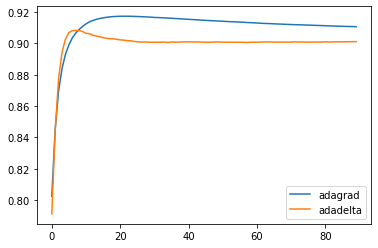

adagrad_auc max: 0.9173147
adadelta_auc max: 0.90827477


In [10]:
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()

print("adagrad_auc max:", max(adagrad_auc))
print("adadelta_auc max:",max(adadelta_auc))

Final hybrid model 

In [31]:
model = LightFM(loss='warp',
                random_state=random_state,
                learning_rate=learning_rate,
                learning_schedule = 'adadelta',
                no_components=30,
                user_alpha=user_alpha)

model = model.fit(train,
                  item_features=item_features,
                  epochs=25,
                  num_threads=num_threads, verbose=True)

train_auc = auc_score(model, train, item_features=item_features).mean()
test_auc = auc_score(model, test, item_features=item_features).mean()

print("train_auc:",train_auc,"\ntest_auc:",test_auc)


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
train_auc: 0.97192395 
test_auc: 0.9503864


In [60]:
'''
import pickle
filename = 'final_hybrid_model.sav'
pickle.dump(model, open(filename, 'wb'))
'''

Hybrid model tuning, very slow

In [78]:
random_state=2020
learning_rate=0.05
no_components=30
alpha=0.000005
num_threads=2
epochs = 120

adagrad_model_f = LightFM(no_components=no_components,
                        loss='warp',
                        learning_schedule='adagrad',
                        user_alpha=alpha,
                        item_alpha=alpha)
adadelta_model_f = LightFM(no_components=no_components,
                        loss='warp',
                        learning_schedule='adadelta',
                        user_alpha=alpha,
                        item_alpha=alpha)


adagrad_auc = []

for epoch in range(epochs):
    adagrad_model_f.fit_partial(train, item_features=item_features, epochs=1)
    adagrad_auc.append(auc_score(adagrad_model_f, test, item_features=item_features).mean())
    #print(epoch, adagrad_auc[-1])
    
print("adagrad finished")


adadelta_auc = []

for epoch in range(epochs):
    adadelta_model_f.fit_partial(train, item_features=item_features, epochs=1)
    adadelta_auc.append(auc_score(adadelta_model_f, test, item_features=item_features).mean())
    #print(epoch, adadelta_auc[-1])
    
print("adadelta finished")

adagrad finished
adadelta finished


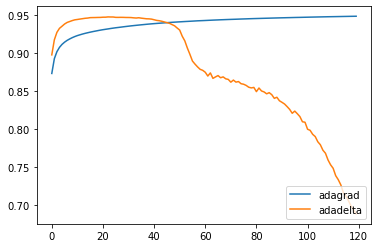

adagrad_auc max: 0.94852895
adadelta_auc max: 0.94764113


In [107]:
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()

print("adagrad_auc max:", max(adagrad_auc))
print("adadelta_auc max:",max(adadelta_auc))


Recommendation Demo

In [75]:
# This function was produced by @author: Aayush Agrawal
def sample_recommendation_user(model, interactions, user_id, user_dict, 
                               item_dict,threshold = 0.5,nrec_items = 10, show = True):
    '''
    Function to produce user recommendations
    Required Input - 
        - model = Trained matrix factorization model
        - interactions = dataset used for training the model
        - user_id = user ID for which we need to generate recommendation
        - user_dict = Dictionary type input containing interaction_index as key and user_id as value
        - item_dict = Dictionary type input containing item_id as key and item_name as value
        - threshold = value above which the rating is favorable in new interaction matrix
        - nrec_items = Number of output recommendation needed
    Expected Output - 
        - Prints list of items the given user has already bought
        - Prints list of N recommended items  which user hopefully will be interested in
    '''
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interactions.loc[user_id,:][interactions.loc[user_id,:] >= threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    if len(scores) < nrec_items:
        nrec_items = len(scores)
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print("User ID", user_id, "Known Likes:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1

        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1
    return return_score_list
    



In [ ]:
'''
loaded_model = pickle.load(open(filename, 'rb'))
#model = loaded_model
'''

In [76]:
user_book_rating = pd.pivot_table(rating_lightfm_tranformed, index='user_id', columns='book_id', values='rating')
user_book_rating = user_book_rating.fillna(0)
item_dict ={}
df = books.loc[books['book_id'].isin(book_sample)][['book_id', 'title']].reset_index()
for i in range(df.shape[0]):
    item_dict[(df.loc[i,'book_id'])] = df.loc[i,'title']
user_dict = dataset._user_id_mapping


sample_recommendation_user(model, interactions=user_book_rating, user_id=34784, user_dict=user_dict, 
                               item_dict=item_dict,threshold = 0.5,nrec_items = 10, show = True)

User ID 34784 Known Likes:
1- Vampires are Forever (Argeneau #8)
2- Vampire, Interrupted (Argeneau #9)
3- A Bite to Remember (Argeneau #5)
4- Single White Vampire (Argeneau #3)
5- Love Bites (Argeneau #2)
6- Bite Me If You Can (Argeneau #6)
7- Rusty Nailed (Cocktail, #2)
8- Boy Meets Girl (Boy, #2)
9- RoomHate
10- Frigid (Frigid, #1)
11- Avalon High
12- Archer's Voice
13- Beautiful Stranger (Beautiful Bastard, #2)
14- The Vincent Boys (The Vincent Boys, #1)
15- This Man Confessed (This Man, #3)
16- The Boy Next Door (Boy, #1)
17- Queen of Babble (Queen of Babble, #1)
18- Beneath This Man (This Man, #2)
19- Wait for You (Wait for You, #1)
20- Beautiful Bastard (Beautiful Bastard, #1)
21- Wallbanger (Cocktail, #1)
22- Angus, Thongs and Full-Frontal Snogging (Confessions of Georgia Nicolson, #1)
23- Nights in Rodanthe
24- Easy (Contours of the Heart, #1)
25- The Princess Diaries (The Princess Diaries, #1)
26- The Sisterhood of the Traveling Pants (Sisterhood, #1)
27- Fifty Shades Darker (

[3311, 429, 3237, 77, 3584, 319, 6611, 5839, 1337, 6031]